
# Quantum random walks
Vizualising with animations some of the things discussed and examplified in:

Kempe, J. “Quantum Random Walks: An Introductory Overview.” Contemporary Physics 44.4 (2003): 307–327. Crossref. Web.
arXiv:quant-ph/0303081 

and also the search algorithm in 

Shenvi, Neil, Julia Kempe, and K. Birgitta Whaley. "Quantum random-walk search algorithm." Physical Review A 67.5 (2003): 052307.


all calculations are done in plain numpy (as en exercise of quantum calculations, of course it would be easier and more elegant to use e.g. cirq)

animation of plots copied from Parul Pandey's post https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c 

TODO: try plotly for animation

### Overview:
1. Random walk on the circle, animation of distribution and cesaro limit
   - classical 
   - quantum random walk: use different coins, some plots about resulting walks
2. Random walk on hypercubea. 
   - classical 
   -  quantum random walk: use different coins, some plots about resulting walks
3. Quantum random walk search - variant of Grover's
    - vizualise how the target node accumulates probability

In [8]:
# IMPORTS AND SETTINGS
import numpy as np
import itertools
import os
import sys
#import re
import collections
from scipy.sparse import csr_matrix
from scipy.stats import unitary_group
import time

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline   
plt.style.use('seaborn-pastel')

# OWN UTILS
from utils.matplot_animations import classic_animation, animate_probs_evol
from utils.calculations import run_state_evol

# 1. Integers line graph 

## classic random walk on integers

grid transition matrix is in implemented as circle, for simulation of unbounded line n_steps >= n can be used,

1) unbounded, set e.g. n=201 and n_steps to n//2 to see simulated unbounded walk.

2) circle graph, set e.g. n=13 and n_steps to 200 to see how the random walk approached uniform distribution on a circle, if left and right probabilities are asymmetric, .e.g. go_left_prob=0.3, it gives rise to a damped oscillation



In [91]:
## represented as markov chain with transition matrix T
n = 13  # number of grid points (graph nodes), pick only ODD numbers to have symmetry for plots,
#  if n//2 is odd graph is shortened 2 nodes for plotting, since border nodes have zero prob in even time points  
go_left_prob = 0.3
go_right_prob = 1 - go_left_prob 
# prepare transition matrix, only border transitions must be adjusted below
T = np.diag(go_left_prob*np.ones(n-1),k=-1) + np.diag(go_right_prob*np.ones(n-1),k=1)
## for circle glue border points, an edge between opposite border nodes is added
T = T + np.diag(go_left_prob*np.ones(1),k=(n-1)) + np.diag(go_right_prob*np.ones(1),k=-(n-1))

state_0 = np.zeros(n)
state_0[n//2] = 1 # if n is odd this is the mid-point
# look at matrix of graph
#print((T>0).astype(int))

MovieWriter imagemagick unavailable. Trying to use pillow instead.


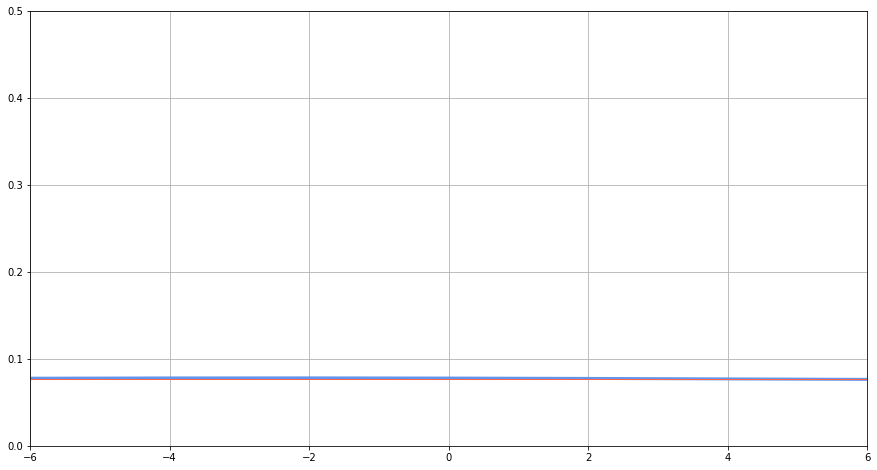

In [92]:
## use custom util to run the above defined markov chain and create animation 
classic_animation('circle_classic_walk',transition=csr_matrix(T),projection=None, 
                  start_pd= state_0,n_steps=200,show_equil=True,frame_option='even')

## quantum random walk on integers

### define graph on which random walk takes place

n = number of nodes

d = dimension of direction space

each edge has two labels from 1,...,d one label for each direction of the edge, this label defines which dimension of the direction space is shifted along the edge in the given direction. 

In [93]:
n = 60
d = 2
graph = { # this defines a circle graph with 2 dimensional direction space, one for each direction on the circle
    'edges': np.column_stack((np.arange(0,n),np.arange(1,n+1)%n)).astype(int),
    'fw_edge_labels': 0 * np.ones(n).astype(int) ,
    'bw_edge_labels': 1 * np.ones(n).astype(int)
}
# define the state at time 0
start_state = np.zeros((n,d)).astype(np.complex64)
start_state[n//2,:] = np.array([1,1])*(1/np.linalg.norm(np.array([1,1])))


### coin flip operator 
pick one from some operators listed below  

In [94]:
# Hadamard coin for symmetric walk
H = (2**-0.5) * np.array([[1,1],[1,-1]])

# other coin for symmetric walk
B = (2**-0.5) * np.array([[1.0,1.0j],[1.0j,1.0]])

# random unitary operator as coin
R = unitary_group.rvs(2)

# example 1, for a very poky peak
R1 = np.array([[0.76954316+0.61581413j, 0.13368382-0.10346458j],
       [0.01722725-0.16816511j, 0.92940165+0.3280797j ]])
# example 2 very slow moving single peak
R2 = np.array([[ 0.04131961-0.15318137j,  0.29812037+0.94125045j],
       [-0.19448819+0.9679889j ,  0.05765715+0.14780898j]])


# PICK ONE
C = R
print('determinant=',np.linalg.det(C))
print('angle of determinant',np.angle(np.linalg.det(C)))

determinant= (-0.5696287192199254+0.8219021366561028j)
angle of determinant 2.176850377693959


In [95]:
## run the quantum random walk given number of steps
n_steps = 80
# state_evol is array of all consecutive states
state_evol = run_state_evol(graph=graph, coin_mat=C, start_state=start_state , n_steps = n_steps)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------1.7881393e-07


MovieWriter imagemagick unavailable. Trying to use pillow instead.


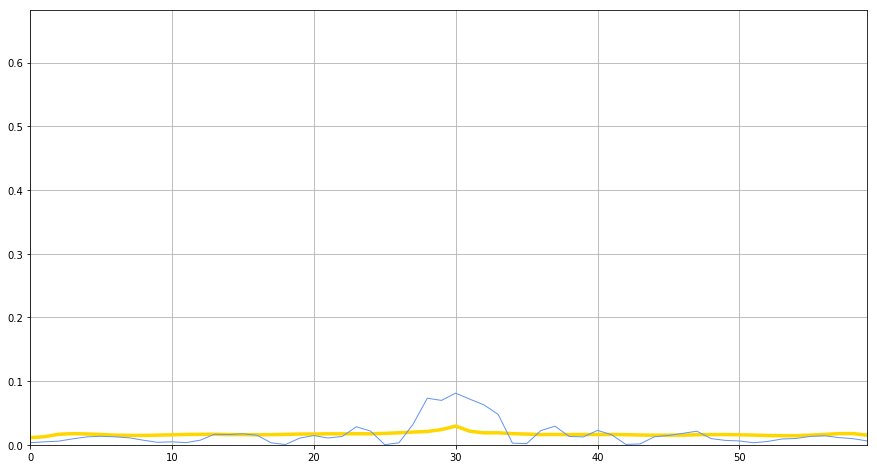

In [96]:
## animation of whole time evolution
animate_probs_evol('circle_quantum_walk', state_evol, projection=np.diag(np.ones(n)), show_equil=False, frame_option='pairsmean')

### Analysis of the quantum random walk

- plot the maximal probability on one single node over time and in parallel plot the maximal absolute values of the dimensions of the direction space over time: this probability decreases oscillating but seems to saturate well above a value 1/n which would indicate uniform distribution
- plot the position index of node with maximal probability over time: the maximum walks the circle step by step
- plot the position index of node with maximal absolute value in each dimension of direction space over time


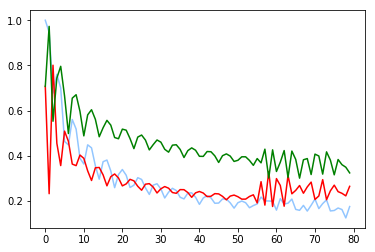

In [17]:
plt.plot((np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2).max(axis=0))
plt.plot(np.abs(state_evol[:,0,:]).max(axis=0),'r')
plt.plot(np.abs(state_evol[:,1,:]).max(axis=0),'g')

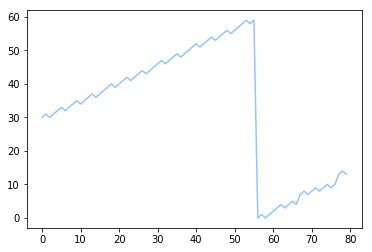

In [18]:
plt.plot(np.argmax(np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2,axis=0))

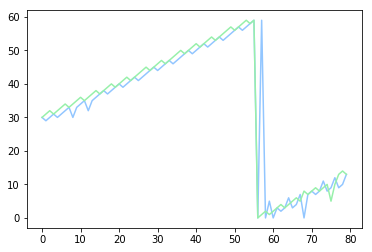

In [25]:
# for aplitudes
plt.plot(np.argmax(np.abs(state_evol[:,0,:]),axis=0))
plt.plot(np.argmax(np.abs(state_evol[:,1,:]),axis=0))

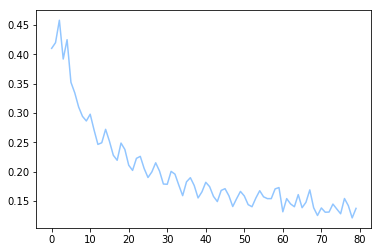

In [28]:
# plot quantiles of probability dist over time or over projected nodes
plt.plot(np.quantile((np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2),0.99,axis=0))

In [23]:
## from the state evolution, get the evolution of the probability distribution on the nodes
probs_evol = np.linalg.norm(state_evol,ord=2,axis=1)**2

# 2. Hypercube graph

In [97]:
# number of dimensions of hypergraph
d = 12

#### create array of edges in hypergraph
the naive way, i.e. checking all pairs for hamming distance 1, is not feasible for high d where total pair number too high
the networkx function to create hypergraph can be used instead


In [98]:
# the naive way, i.e. checking all pairs for hamming distance 1, is too slow, takes 20 sec for d=12 already
# hycube0 = np.array([[x,y] for (x,y) in itertools.combinations(range(2**d),2) if bin(x^y).count('1')==1 ])

In [99]:
# load networkx and define a function to convert binary tuples as in networkx representation into integers
import networkx as nx
def bintuple2int(bintuple):
    return sum(2**np.where(bintuple)[0])

In [100]:
hycube = nx.hypercube_graph(d) # create nx object overwrite it with array in next line
hycube = np.array([[bintuple2int(x),bintuple2int(y)] for (x,y) in hycube.edges])
#hycube = np.column_stack((hycube,hycube[:,::-1]))

In [101]:
###  projection on the hamming weights of nodes
P = np.zeros((d+1,2**d))
for i in range(2**d):
    P[bin(i).count('1'),i] = 1
# normalize so that hycube projected distribution is a prob distribution   
#P = np.diag(1/P.sum(axis=1)).dot(P)
P = csr_matrix(P)

## classic random walk on hypercube

In [102]:
T = np.zeros((2**d,2**d))
T[hycube[:,0],hycube[:,1]] = 1/d
T = T + T.T
T = csr_matrix(T)

In [103]:
assert(np.all((T>0).sum(axis=0)==d))

In [104]:
# initial state
state_0 = np.zeros(2**d)
state_0[0] = 1 
n_steps = 20 

MovieWriter imagemagick unavailable. Trying to use pillow instead.


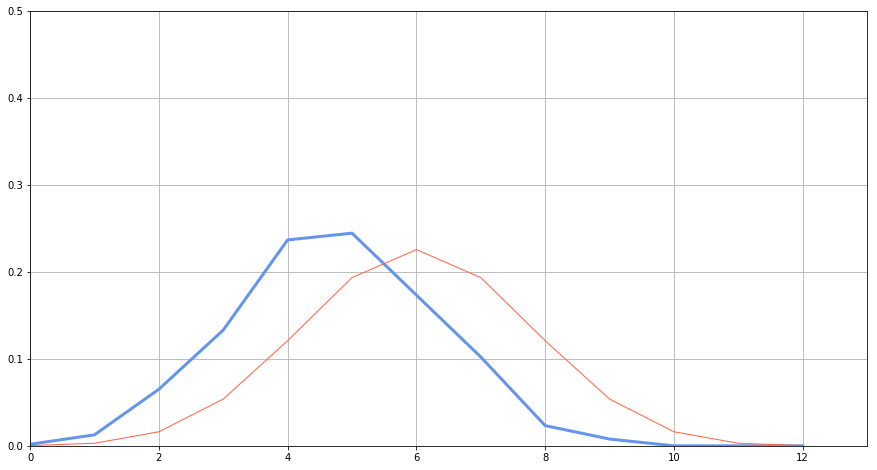

In [105]:
# run the walk and get animated plot
# nodes are bucketed in hamming weights a red line is showing the uniform distribution for visual reference
classic_animation( 'hypercube_classic_walk', transition=T, projection=P, 
                  start_pd=state_0, n_steps=10, show_equil=True, frame_option='pairsmean')

TODO: animation too slow and not interesting for classic hypercube walk
instead, maybe plot distribution at four time points
and calculate time to equilibrium analytically


## quantum walk on the hypercube

In [106]:
n_steps = 50    # number of steps to simulate
state_0 = np.zeros((2**d,d)).astype(np.complex64)
# add new dimension to represent state at each discrete time point, i.e. after each step (assume max num of steps)
state_evol = np.repeat(state_0[:,:,np.newaxis],n_steps,axis=2)
print('state_evol.shape:',state_evol.shape,'\ndtype:',state_evol.dtype )

# define starting state at location 0 and time point 0
state_evol[0,:,0] = np.ones((d))
state_evol[0,:,0] = state_evol[0,:,0]*(1/np.linalg.norm(state_evol[0,:,0]))

print('starting state at location zero, spin =',state_evol[0,:,0])

state_evol.shape: (4096, 12, 50) 
dtype: complex64
starting state at location zero, spin = [0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j
 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j
 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j]


#### coins

In [107]:
## DFT matrix is the vandermonde matrix of the d-th unit root omega
omega = np.exp(2*np.pi*1.0j/d)
V = (d**-0.5)*np.vander(omega**range(d), d, increasing=True)

## grover coin
G = (2/d)*np.ones((d,d)) - np.diag(np.ones(d))

# PICK ONE
C = G

#### create graph 
with edge lables for defining the quantum walk

In [108]:
edge_labels = [int(np.log2(x^y)) for (x,y) in hycube]
graph = {'edges':hycube, 'fw_edge_labels':edge_labels, 'bw_edge_labels':edge_labels}
n_steps = 50    # number of steps to simulate
start_state = np.zeros((2**d,d)).astype(np.complex64)
start_state[0,:] = np.ones((d,))*(1/np.linalg.norm(np.ones((d,))))
print(start_state[0,:])

[0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j
 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j
 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j]


#### run quantum walk, get state evolution

In [109]:
state_evol = run_state_evol(graph=graph, coin_mat=C, start_state=start_state , n_steps = n_steps, probsum_tol=1e-4)

-------------------------------------------------
-------------------------------------------------3.6120415e-05


MovieWriter imagemagick unavailable. Trying to use pillow instead.


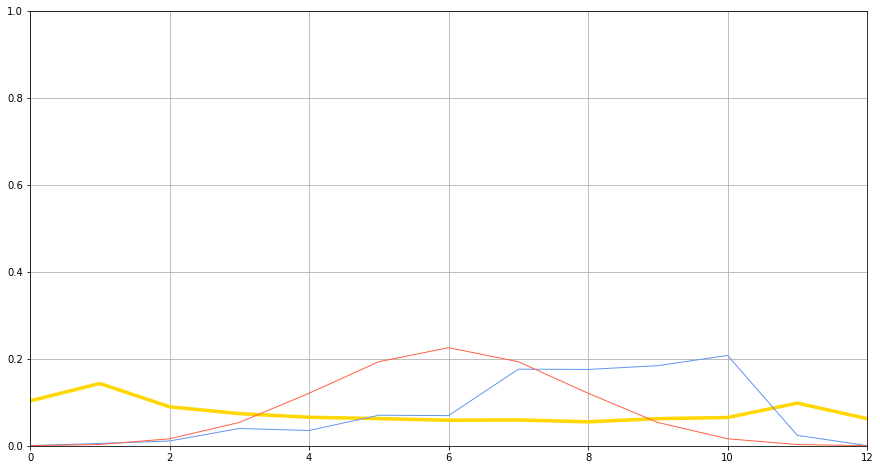

In [110]:
# get animated plot as gif
animate_probs_evol('hypercube_quantum_walk', state_evol, projection=P, show_equil=True, frame_option='pairsmean')

### some plots about the state evolution
it seems that the walk peridically accumualates a lot of probability in the start state and then in the opposite state, while all other states are never getting a lot of probability, rather the walk takes all the routes at once between the opposite states, hence distributing the probability among many states

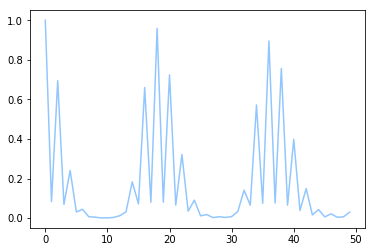

In [56]:
### plot of maximum prob in one state over time
plt.plot( (np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2).max(axis=0) )

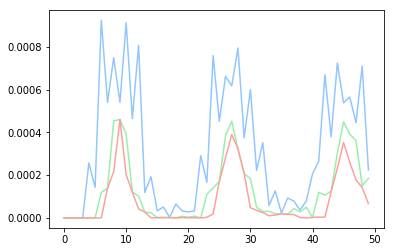

In [57]:
# or with quantiles instead
plt.plot(np.quantile((np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2),0.9,axis=0))
plt.plot(np.quantile((np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2),0.7,axis=0))
plt.plot(np.quantile((np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2),0.6,axis=0))



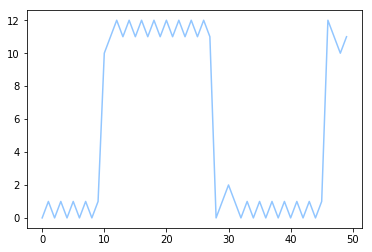

In [59]:
## hamming distance of maximum position to start state zero
plt.plot([bin(x).count('1') for x in np.argmax(np.linalg.norm(state_evol[:,:,:],ord=2,axis=1)**2,axis=0)])

## 3. Random walk search variant of Grover's algorithm (shelvi, kempe, whaley paper)
use preparation of random walk on hypercube as above

In [111]:

edge_labels = [int(np.log2(x^y)) for (x,y) in hycube]
graph = {'edges':hycube, 'fw_edge_labels':edge_labels, 'bw_edge_labels':edge_labels}
n_steps = 50    # number of steps to simulate
start_state = np.zeros((2**d,d)).astype(np.complex64)
start_state[0,:] = np.ones((d,))*(1/np.linalg.norm(np.ones((d,))))
print(start_state[0,:])

[0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j
 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j
 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j 0.28867513+0.j]


In [112]:
## grover coin
G = (2/d)*np.ones((d,d)) - np.diag(np.ones(d))
G.shape

(12, 12)

In [113]:
## uniform start state
unif_state = np.ones((2**d,d)).astype(np.complex64)*(((1/d)**0.5)/(2**d)**0.5)

In [114]:
assert(abs((np.linalg.norm(unif_state,ord=2,axis=1)**2).sum()-1)<1e-6)

In [115]:
##
mrk_state_coin = - np.diag(np.ones((d,))).astype(np.complex64)
marked_state = 0
n_steps = 20
state_evol = run_state_evol(graph=graph, coin_mat=G, start_state=unif_state , n_steps = n_steps, probsum_tol=1e-3,
                           marked_state=marked_state, mrk_state_coin=mrk_state_coin)


-------------------
-------------------2.2411346e-05


In [116]:
# from the state evolution get the evolution of probability distribution
probs_evol = np.linalg.norm(state_evol,ord=2,axis=1)**2

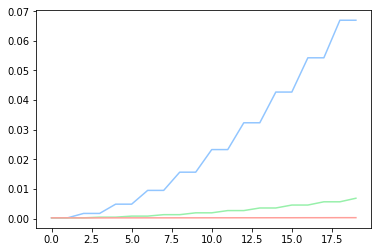

In [83]:
# compare the evolution of probability in the marked node to the next neighboring node and a further node
plt.plot(probs_evol[0,:])
plt.plot(probs_evol[1,:])
plt.plot(probs_evol[5,:])


### animate plot as gif

MovieWriter imagemagick unavailable. Trying to use pillow instead.


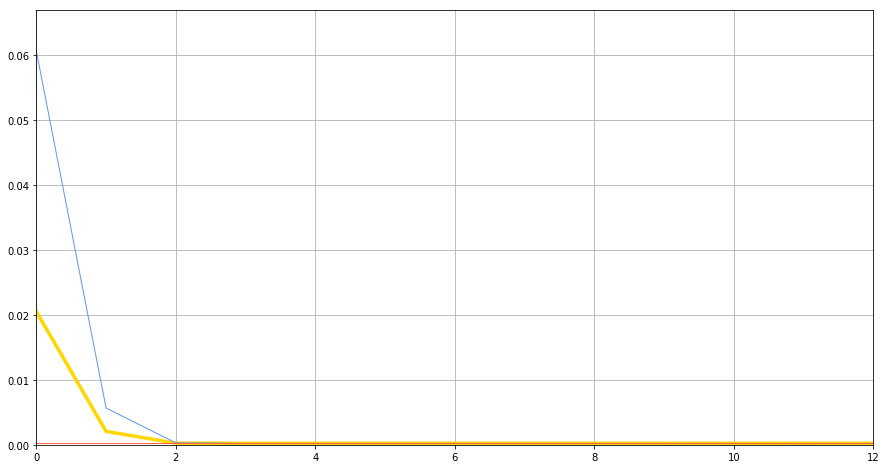

In [118]:
animate_probs_evol('hypercube_search', state_evol, projection=P, show_equil=True,show_cesaromean=True,
                       scale_projection=True, frame_option='pairsmean')